# Feature Selection / Extraction
Here, we will look at common ways to reduce overfitting by regularization and dimensionality reduction via feature selection, which leads to simpler models by requiring fewer parameters to be fitted to the data. One is to use L1 loss due to its sparse solutions. you can read more about it on internet

There are two main categories of dimensionality reduction techniques: feature selection and feature extraction. Via feature selection, we select a subset of the original features, whereas in feature extraction, we derive information from the feature set to construct a new feature subspace. Here we will deal with one of the feature selection algo's

Sequential feature selection algorithms are a family of greedy search algorithms that are used to reduce an initial d-dimensional feature space to a k-dimensional feature subspace where k<d. The motivation behind feature selection algorithms is to automatically select a subset of features that are most relevant to the problem, to improve computational efficiency, or to reduce the generalization error of the model by removing irrelevant features or noise, which can be useful for algorithms that don’t support regularization.

### Sequential Backword Selection (SBS)
A classic sequential feature selection algorithm is sequential backward selection (SBS), which aims to reduce the dimensionality of the initial feature subspace with a minimum decay in the performance of the classifier to improve upon computational efficiency.

In [16]:
import numpy as np 
import pandas as pd
from itertools import combinations
from sklearn.base import clone
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [22]:
class SBS:
    def __init__(self, estimator, k_features, scoring=accuracy_score, test_size=0.3, random_state = 1):
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.scoring = scoring
        self.test_size = test_size
        self.random_state = random_state
    def fit(self, X,y):
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=self.test_size, stratify=y)
        dim = X.shape[1]
        self.indices_ = tuple(range(dim))
        score  = self.calc_score_(X_train, y_train, X_test, y_test, self.indices_)
        self.subsets_ = [self.indices_]
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            combs = []
            for p in combinations(self.indices_, r=dim - 1):
                score = self.calc_score_(X_train, y_train, X_test, y_test, p)
                scores.append(score)
                combs.append(p)
            best  = np.argmax(scores)
            self.indices_ = combs[best]
            self.subsets_.append(self.indices_)
            self.scores_.append(scores[best])
            dim  = dim - 1
        self.k_score = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def calc_score_(self,X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:,indices],y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score  = self.scoring(y_test, y_pred)
        return score


In [23]:
# import wine data
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol','Malic acid', 'Ash','Alcalinity of ash', 'Magnesium','Total phenols', 'Flavanoids', 
                  'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue','OD280/OD315 of diluted wines','Proline']

In [24]:
X = df_wine.values[:,1:]
y = df_wine.values[:,0]


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [26]:
ss = StandardScaler()
ss.fit(X_train)
X_train_std = ss.transform(X_train)
X_test_std = ss.transform(X_test)

In [27]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

In [28]:
knn = KNeighborsClassifier(n_neighbors= 5)
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

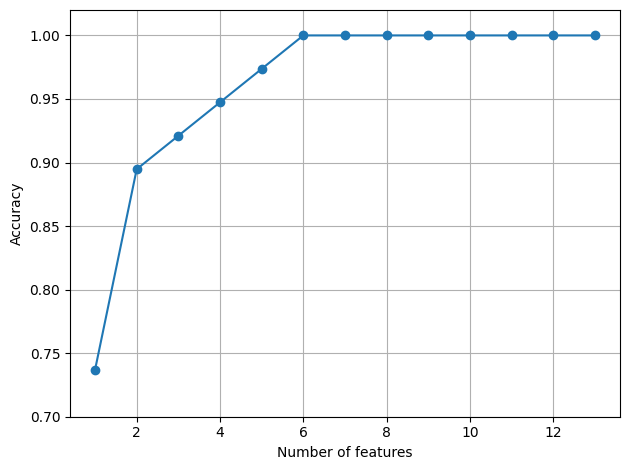

In [31]:
k_feat = [len(k) for k in sbs.subsets_]
plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
plt.show()

In [32]:
print(k_feat)

[13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]


In [59]:
k6 = list(sbs.subsets_[7])

In [60]:
print(df_wine.columns[1:][k6])

Index(['Alcohol', 'Malic acid', 'Alcalinity of ash', 'Magnesium',
       'Total phenols', 'Color intensity'],
      dtype='object')


In [61]:
knn.fit(X_train_std, y_train)
print('Training accuracy:', knn.score(X_train_std, y_train))
print('Test accuracy:', knn.score(X_test_std, y_test))

Training accuracy: 0.9838709677419355
Test accuracy: 0.9444444444444444


In [62]:
knn.fit(X_train_std[:, k6], y_train)
print('Training accuracy:', knn.score(X_train_std[:, k6], y_train))
print('Test accuracy:', knn.score(X_test_std[:, k6], y_test))

Training accuracy: 0.967741935483871
Test accuracy: 0.9259259259259259
